<a href="https://colab.research.google.com/github/trezaB/StockAnalysis/blob/main/stockAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Correlation between RSI limits and returns for Nift 50**

In [137]:
import pandas as pd
import requests
import yfinance as yf
import datetime
import matplotlib.pyplot as plt

1.We try to get the ticker symbols for 50 nifty stocks

In [138]:
url="https://en.wikipedia.org/wiki/NIFTY_50#Constituents"
data=requests.get(url)

2.The ticker symbol for yahoo finance have ".NS" so we append it to the ticker symbols.Next we save the ticker symbols in a list 1

In [139]:
data=pd.read_html(url)[2]
ticker=data.Symbol.apply(lambda x:x+".NS")

The start dates are taken when nifty regained precovid levels to avoid step price fluctuations due to covid market crash

In [ ]:
start=datetime.datetime(2020,11,13)
stock_record=pd.DataFrame()
for i in ticker:
  try:
    stock=yf.download(i,start=start,progress=True)
    if len(stock):
      stock['Name']=i
      stock_record=pd.concat([stock_record,stock])
  except Exception as e:
    print(e)


Now we calculate the rsi values
 for each  data with different upper and lower limit

In [141]:
#this function is used to find RSI
def rsi(dataSeries,period=14,ema=True):
    """

    :param dataSeries: closing price for the stock
    :param period: the look back period
    :param ema: if we are consider ema or simple moving average
    :return: this will return a series of RSI values
    """
    #delta=dataSeries
    delta=dataSeries.diff()
    #now we make two series lets try with abs and -1
    lowAvg=delta.clip(upper=0).abs()
    highAvg=delta.clip(lower=0)
    #if ema is set then we use the ema function or we use rolling mean function

    if ema:
        gainAvg=highAvg.ewm(com=period,adjust=True,min_periods=period).mean()
        losAvg=lowAvg.ewm(com=period,adjust=True,min_periods=period).mean()

    else:
        gainAvg=highAvg.rolling(window=period).mean()
        losAvg=lowAvg.rolling(window=period).mean()

    rsi=gainAvg/losAvg
    rsiF=100-(100/(1+rsi))

    return rsiF

Lets drop some unwanted rows to improve overall performance.

In [142]:
stock_record.drop(['High','Low','Close','Volume'],axis=1,inplace=True)

Lets calculate the rsi values for the dataframe

In [143]:
stock_record['Rsi']=rsi(stock_record['Adj Close'])
stock_record.dropna(inplace=True)

Now lets run the vanilla RSI strategy against different lower and upper limits to get the best combination across for buy and sell.Since we are considering swing trading we take holding period of 8 days
The logic used is :-


*   Check if RSI is below lower limit for days closing price
*   If yes we buy at the next days opening.
*   For selling we sell when either the proce is above the higher limit
*   Or the holding period is over

Lets first define the function that produces buy and sell signal





In [144]:
def rsiStrategy(df,lowR=40,upR=60,holdN=8,comm=20):
    '''

    :param lowR:the lower limit of rsi buy signal
    :param upR: the upper limit of rsi sell signal
    :param holdN: number of days we hold before cutting a trade
    :param comm: the commision paid for equity buying and selling
    :return: total profit over span of one year with amount being fixed
    '''
    trade=[]
    buy=0
    dayTaken=0
    current=0
    totalLen=len(df)
   # print(totalLen)
    for i in range(totalLen):
        #IF BUY SIGNAL WAS GIVEN ON ANY DAY WE JUST BUY
        if buy:
            current=df['Open'].iloc[i]
            #and mark for next checking
            buy=0
            dayTaken = i
            #print(f"we bought at {current}")
        elif not current and df['Rsi'].iloc[i]<=lowR:
            #generate a buy signal for next day
            buy=1
            #print(f"buy signal generated at {df['Close'].iloc[i]}")
        #now we see if there are any tades taken if yes then check for exit
        elif current and ((df['Rsi'].iloc[i]>=upR) or ((i-dayTaken)>=holdN)):
            #print(f"we are selling at {df['Close'].iloc[i+1]}")
            try:
                trade.append((df['Open'].iloc[i + 1])-current)
            except:
                trade.append((df['Open'].iloc[i])-current)
            current=0
        else:
            pass
    if current and i==(totalLen-1):
        trade.append((df['Open'].iloc[i]) - current)
    profit=sum(trade)
    tradesTaken=len(trade)
    if tradesTaken:
          wins=((sum(1 for x in trade if x>0))/tradesTaken)*100
    else:
      wins=0
    return (profit,wins)

The backtesting strategy will return a dictionary of all the trades taken for each entity

In [157]:
stockResult=pd.DataFrame(columns=["Name","Low","High","Profit","Wins"])
stocksGroup=stock_record.groupby(["Name"])
lowRange=[20,30,40]
upRange=[60,70,80]
for index,stock in stocksGroup:
  for lowR in lowRange:
      for upR in upRange:
        result= rsiStrategy(stock,lowR,upR,8)
        stockResult.loc[len(stockResult)]=[index,lowR,upR,result[0],result[1]]
        #stockResult=pd.concat([stockResult,)])
stockResult

<ipython-input-157-adb3833c48d7>:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for index,stock in stocksGroup:


,Name,Low,High,Profit,Wins
0,ADANIENT.NS,20,60,-1081.000000,0.000000
1,ADANIENT.NS,20,70,-1081.000000,0.000000
2,ADANIENT.NS,20,80,-1081.000000,0.000000
3,ADANIENT.NS,30,60,-990.000000,33.333333
4,ADANIENT.NS,30,70,-990.000000,33.333333
...,...,...,...,...,...
445,WIPRO.NS,30,70,-45.450012,55.555556
446,WIPRO.NS,30,80,-45.450012,55.555556
447,WIPRO.NS,40,60,-125.300018,52.000000
448,WIPRO.NS,40,70,-117.250031,52.000000


In [147]:
import seaborn as sns

In [ ]:
df2 = stockResult.drop_duplicates(subset=['Name',"Profit"])
sns.pairplot(df2,hue="Name")
plt.show()

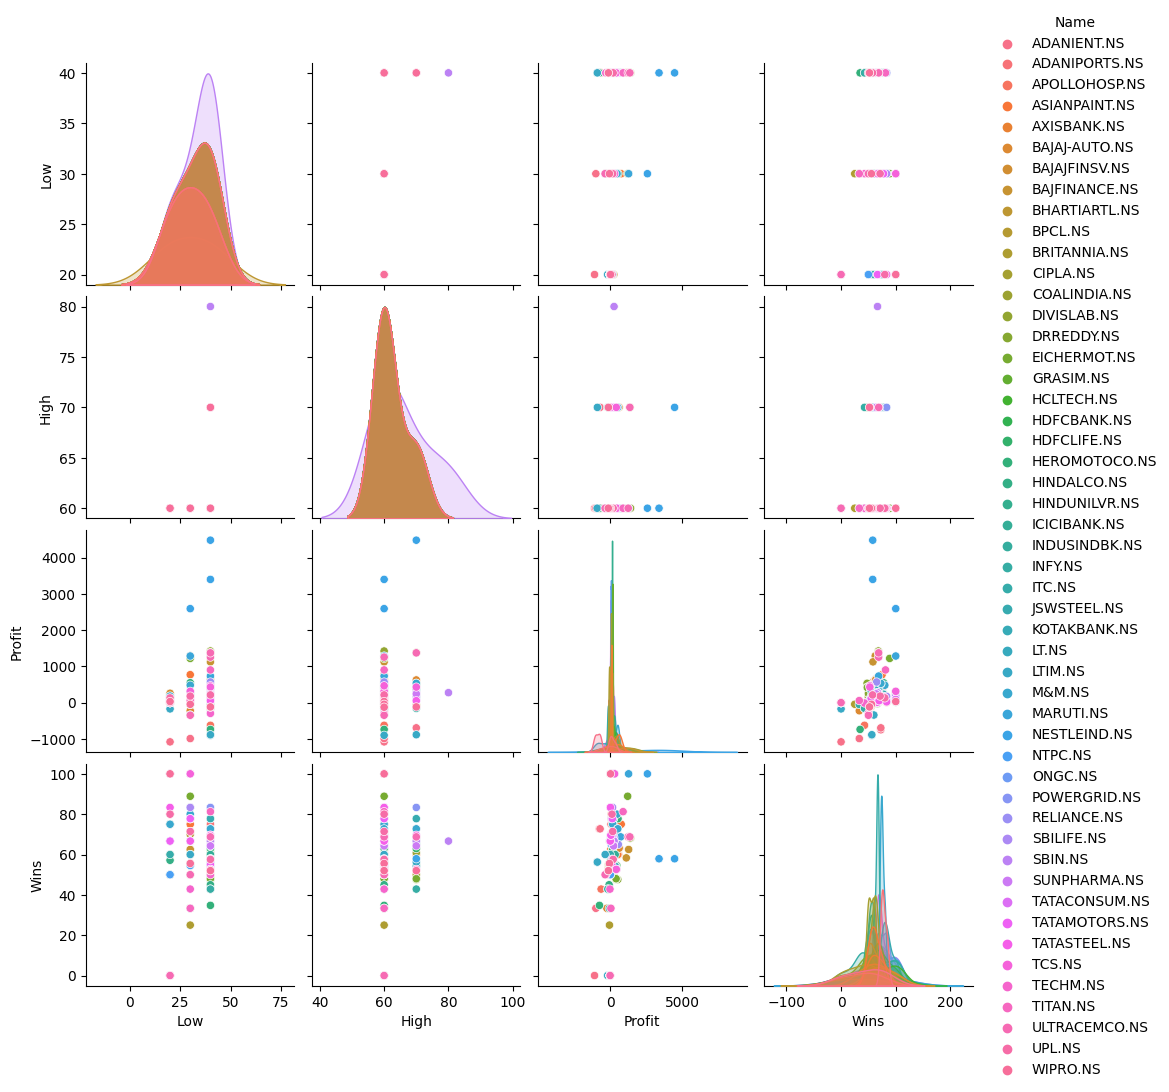

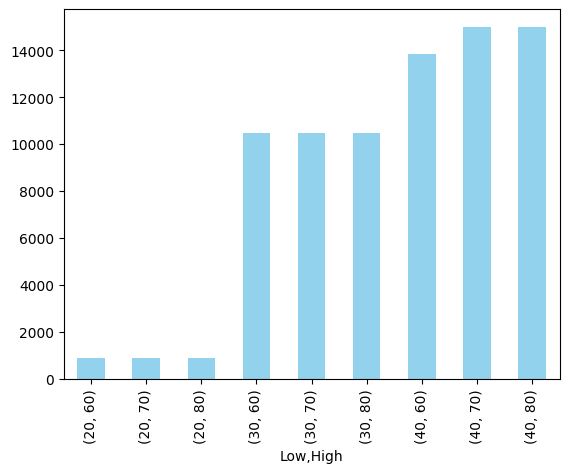

In [170]:
d=stockResult.groupby(["Low","High"])["Profit"].sum()
d.plot(kind="bar",color='skyblue',alpha=0.9)
plt.show()

**Based on the above graph we can conclude that the pair 40,80 will give highest returns for simple RSI strategy **

---
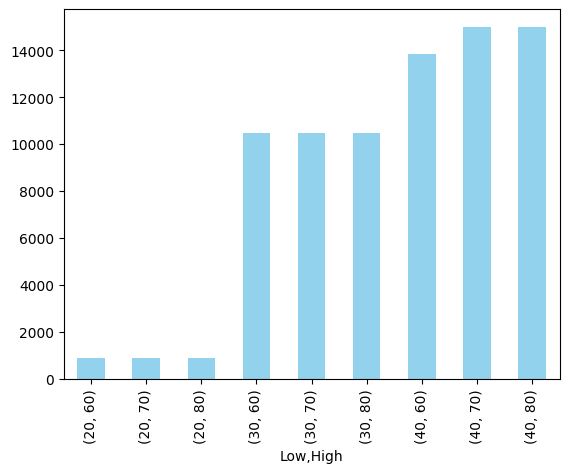
